<a href="https://colab.research.google.com/github/Antoni2000/DynamicBottleneckDetector/blob/main/graph_representations_and_subgraphs_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph representations

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

In [54]:
class Graph:
    def __init__(self):
        self.graph = nx.DiGraph()

    def add_edge(self, vertex1, vertex2):
        self.graph.add_edge(vertex1, vertex2)

    def add_node(self, vertex, name):
        color = 'blue' if 'HL' in name else 'orange' if 'BL' in name else 'yellow'
        self.graph.add_nodes_from([(vertex, {'label': name, 'colour': color})])

    def draw_graph(self):

        pos = nx.kamada_kawai_layout(self.graph)
        labels = nx.get_node_attributes(self.graph, 'label')  # Retrieve node labels
        colors = nx.get_node_attributes(self.graph, 'colour').values()  # Retrieve node colors

        nx.draw(self.graph, pos, with_labels=True, font_color='white', font_weight='bold', node_size=700, node_color=colors, font_size=8)

        labels = nx.get_node_attributes(self.graph, 'label')
        # Draw node labels on one side as a legend
        legend_labels = {node: label for node, label in labels.items() if label}
        for i, (node, label) in enumerate(legend_labels.items()):
            plt.text(1.2, i * 0.1, f"{node}: {label}", color='black', fontsize=8, verticalalignment='center')

        plt.axis('off')

        plt.show()


def parse_graph_data(file_path, node_name_dict, ids = None):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    graphs = []
    current_graph = None

    for line in lines:
        line = line.strip().split()

        if len(line) == 0:
          continue

        if ids:
          if line[0] == 't':
            #print(line[2], ids)
            if int(line[2]) not in ids:
              skip = True
            else:
              skip = False
        else:
          skip = False

        if skip:
          continue

        if line[0] == 't':
            current_graph = Graph()
            graphs.append(current_graph)
        elif line[0] == 'v':
            node = int(line[1])
            current_graph.add_node(node, node_name_dict[int(line[2])])
        elif line[0] == 'e':
            vertex1 = int(line[1])
            vertex2 = int(line[2])
            current_graph.add_edge(vertex1, vertex2)

    return graphs

In [55]:
import os

file_path = os.getcwd() + '/files/GRAPH_NAMES.txt'

with open(file_path, 'r') as file:
    content = file.read()

node_name_dict = {}
lines = content.strip().split('\n')

for line in lines:
    parts = line.split(',')
    key = int(parts[1])  # Extract the last number after the comma
    value = parts[0]  # Extract the part before the comma
    node_name_dict[key] = value


Graph 0:


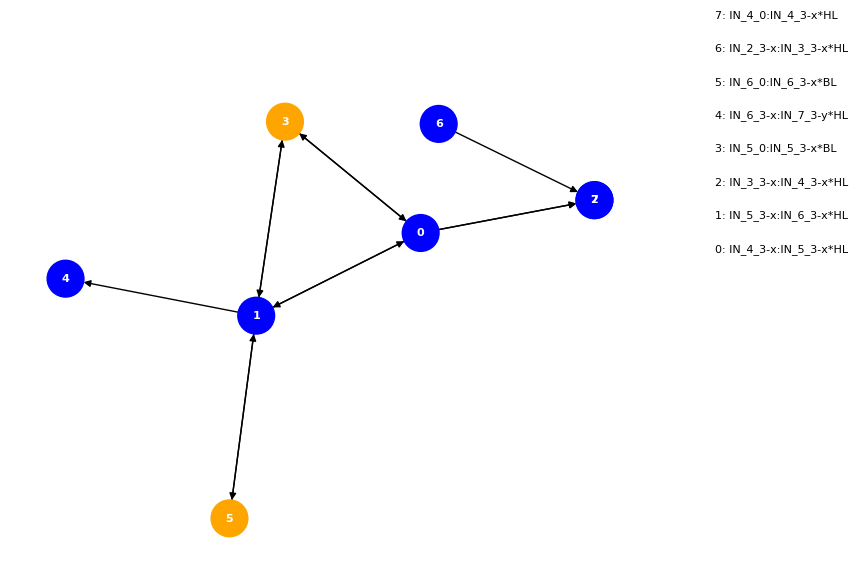

Graph 1:


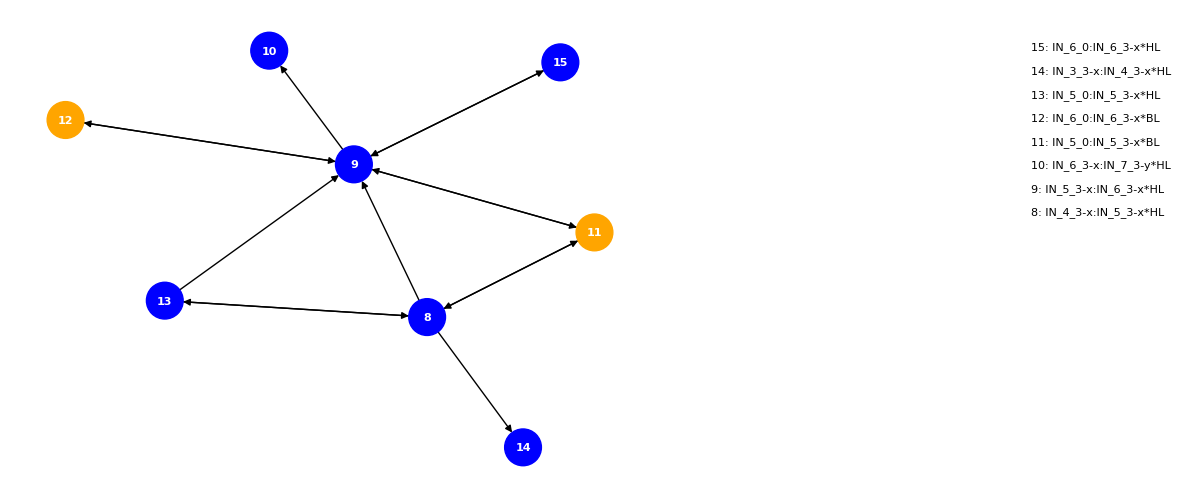

Graph 2:


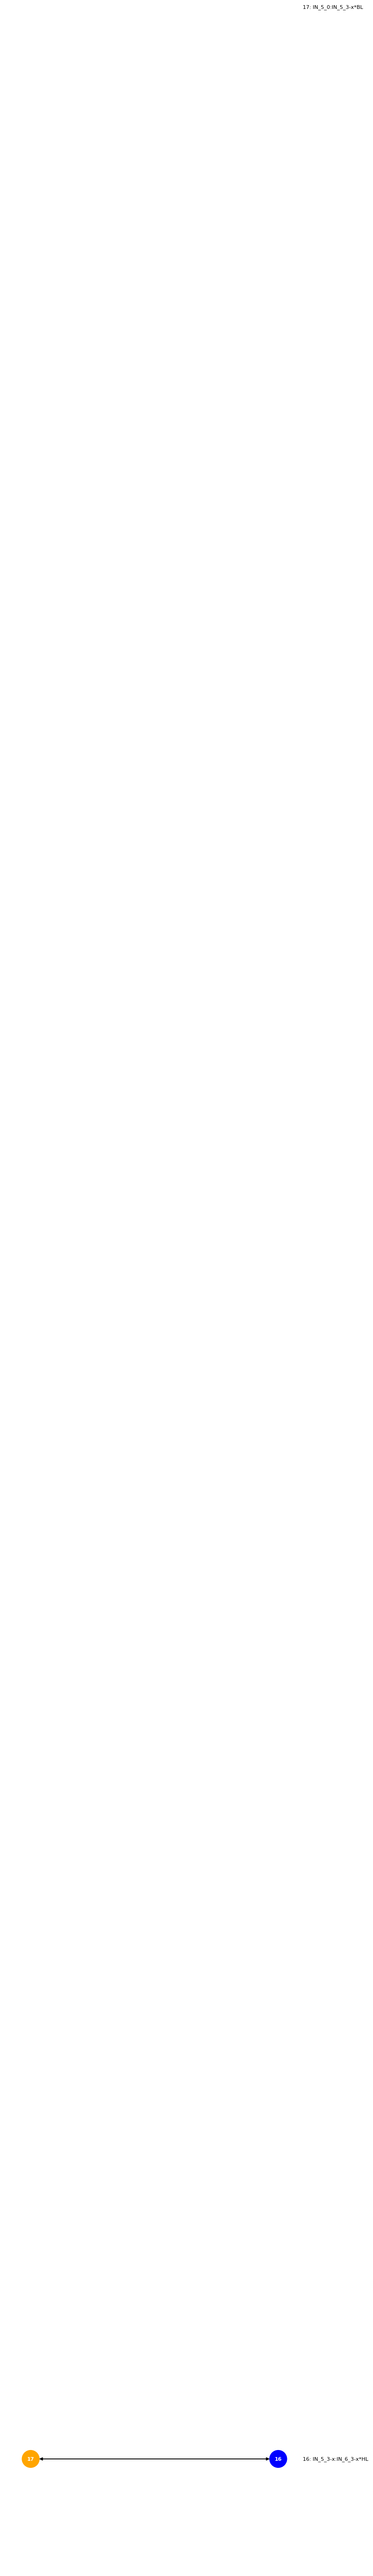

Graph 3:


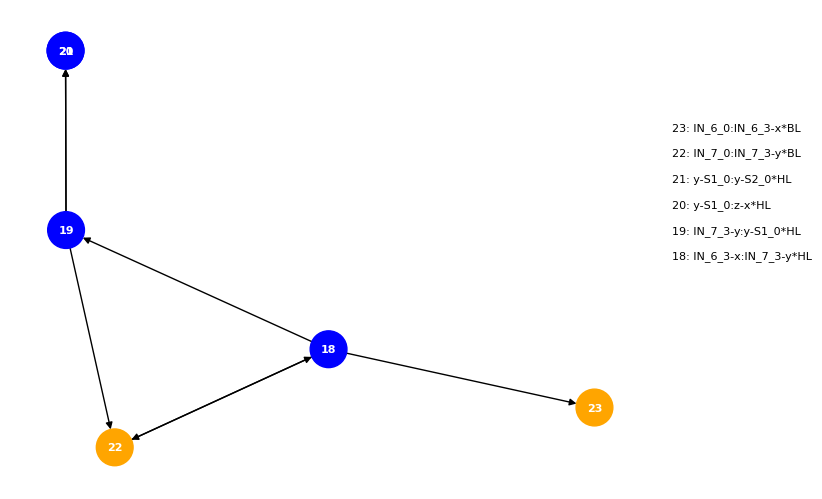

Graph 4:


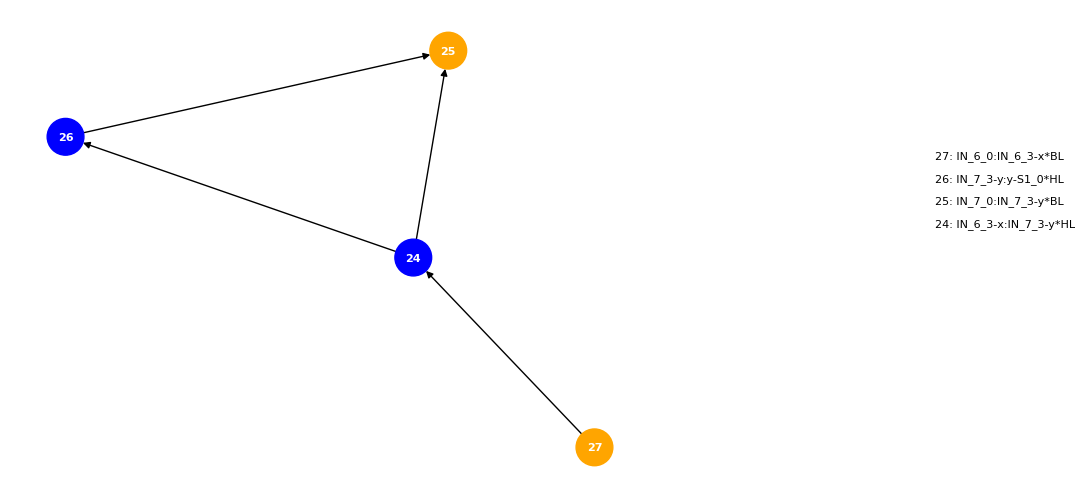

Graph 5:


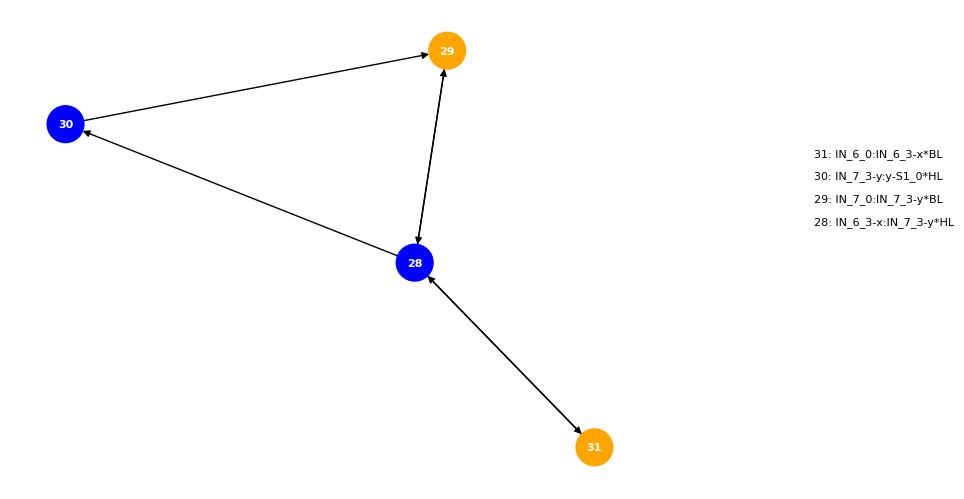

Graph 6:


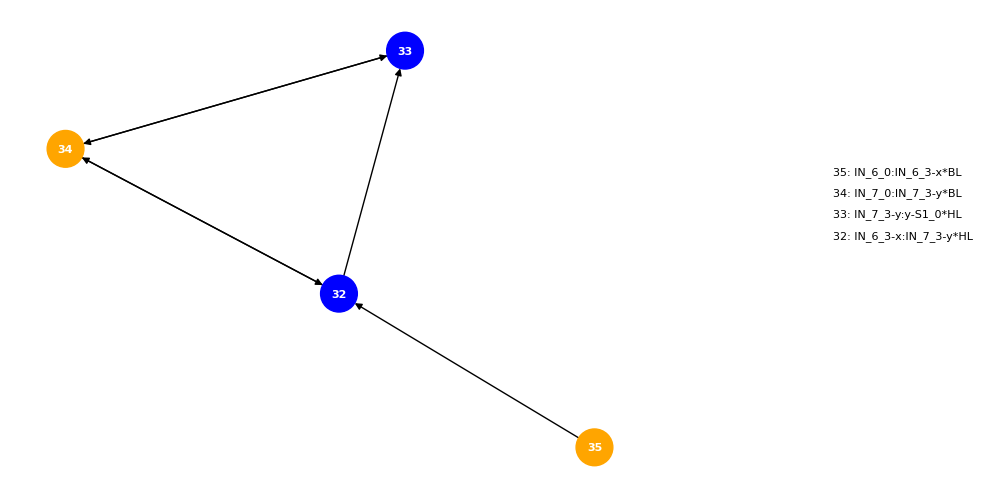

Graph 7:


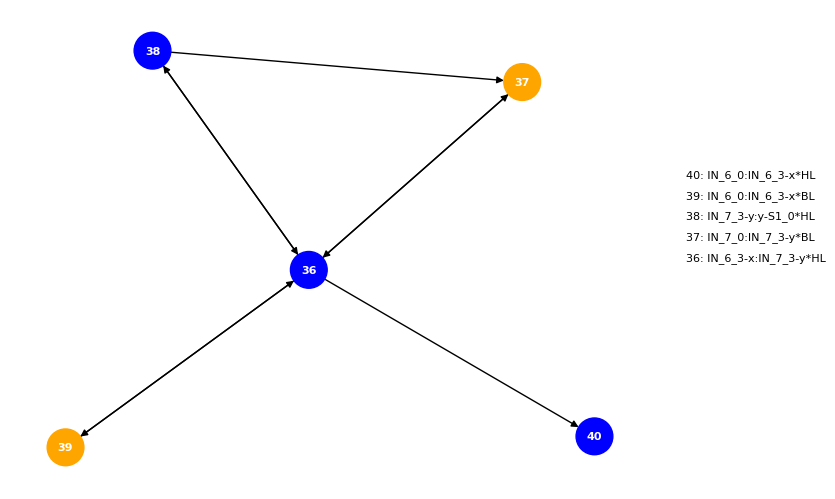

Graph 8:


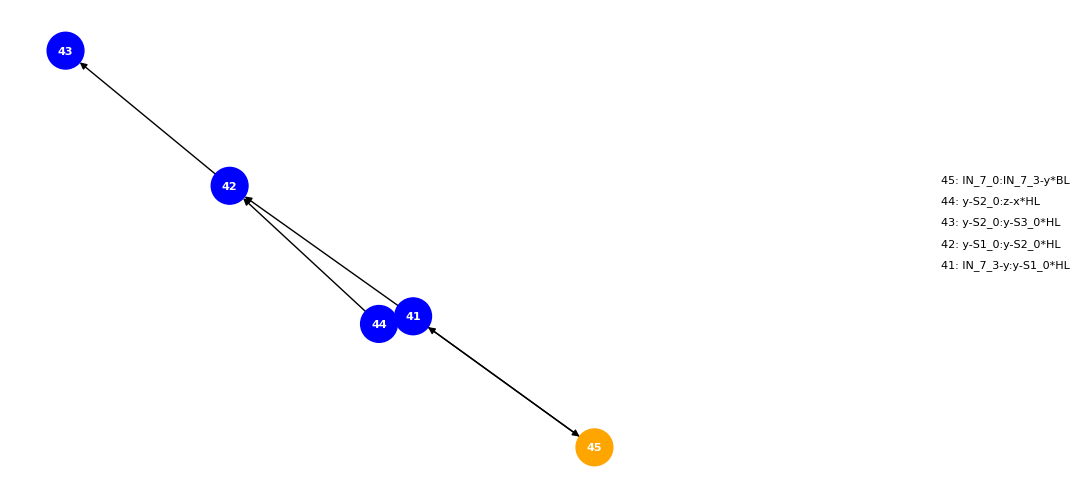

Graph 9:


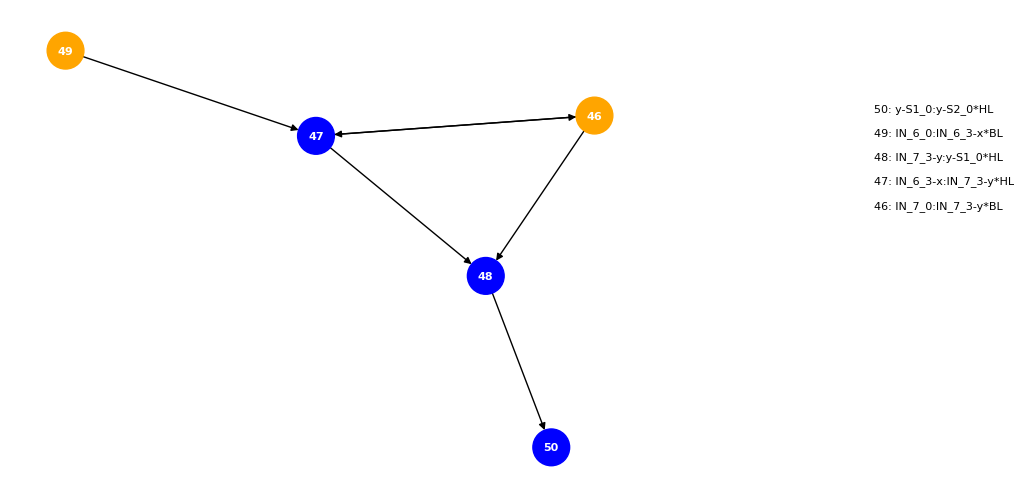

In [56]:
file_path = os.getcwd() + '/files/GRAPH.txt'
graphs = parse_graph_data(file_path, node_name_dict)

for i, graph in enumerate(graphs):
    print(f"Graph {i}:")
    graph.draw_graph()


# Subgraph Patterns

In [47]:
from collections import defaultdict

In [50]:
def parse_input(filename):
    subgraphs = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        current_subgraph = None
        for line in lines:
            tokens = line.strip().split()
            print(tokens)
            if len(tokens) == 0:
              continue
            if tokens[0] == 't':
                if current_subgraph:
                    subgraphs.append(current_subgraph)
                current_subgraph = {'id':-1,'support': 0, 'vertices': [], 'edges': [], 'graphs': [], 'pattern': None, 'BL':False}
                current_subgraph['id'] = int(tokens[2])
                current_subgraph['support'] = 4
            elif tokens[0] == 'v':
                current_subgraph['vertices'].append((int(tokens[1]), int(tokens[2])))
            elif tokens[0] == 'e':
                current_subgraph['edges'].append((int(tokens[1]), int(tokens[2])))
            elif tokens[0] == 'x':
                current_subgraph['graphs'] = list(map(int, tokens[1:]))
        if current_subgraph:
            subgraphs.append(current_subgraph)
    return subgraphs

def classify_subgraphs(subgraphs, node_name_dict):
    blo = 0
    total = 0
    for subgraph in subgraphs:
        # I can check which one happens first for each edge by nowing the first node in the edge, it is a directed graph
        # To know if it is forward/backward/parallel I need to know the the normal track of activities

        forward = False
        backward = False
        parallel = False
        neither = False
        has_blockage = False
        # It is not necessay once it is forward/ nackward/paralell and which node is first check the labels. If converge or diverge  (share?)
        for e in subgraph['edges']:
            # Node v1 happens before v2 by construction (directed graph)
            v1, v2 = e

            for n,id in subgraph['vertices']:
                if n == v1:
                    n1 = id
                if n == v2:
                    n2 = id

            seg1 = node_name_dict[n1]
            seg2 = node_name_dict[n2]

            type1 = seg1.split("*")
            type2 = seg2.split("*")

            if type1[1][:2] == "BL":
                has_blockage = True
            if type2[1][:2] == "BL":
                has_blockage = True

            act11 = type1[0].split(":")[0]
            act12 = type1[0].split(":")[1]

            act21 = type2[0].split(":")[0]
            act22 = type2[0].split(":")[1]

            if act12 == act21:
                forward = True
            elif act11 == act22:
                backward = True
            elif act11 == act21 or act12 == act22:
                parallel = True
            else:
                neither = True

        if has_blockage:
          blo += 1
          subgraph['BL'] = True
          if neither:
              subgraph['pattern'] = 'Neither'
          elif (forward and backward) or (forward and parallel) or (backward and parallel):
              subgraph['pattern'] = 'Mixed'
          elif forward:
              subgraph['pattern'] = 'Forward'
          elif backward:
              subgraph['pattern'] = 'Backward'
          elif parallel:
              subgraph['pattern'] = 'Parallel'
        total += 1
    print(f"Found {blo} subgraphs with at least one blockage from {total}\n")

def subgraph_pattern_freq(subgraphs, min_support = 3, max_support = 6):
    frequencies = defaultdict(int)
    l = list()

    for subgraph in subgraphs:
        if subgraph['BL']:
            support = subgraph['support']
            #print(subgraph['id'], support)
            if min_support <= support and support <= max_support:
                frequencies[subgraph['pattern']] += 1
                l.append((subgraph['id'], subgraph['pattern']))

    return frequencies, l

In [51]:
filename = os.getcwd() + "/files/GRAPH.txt"  # Replace with your actual file name
subgraphs = parse_input(filename)

classify_subgraphs(subgraphs, node_name_dict)

frequencies, id_type = subgraph_pattern_freq(subgraphs, min_support = 1)
# print(frequencies)

for patterntype, count in frequencies.items():
    print(f"Subgraphs {patterntype}: {count} occurrences\n")

print(id_type)

['t', '#', '0']
['v', '0', '1']
['v', '1', '2']
['v', '2', '3']
['v', '3', '4']
['v', '4', '5']
['v', '5', '6']
['v', '6', '7']
['v', '7', '8']
['e', '0', '1', '1']
['e', '0', '2', '1']
['e', '0', '3', '1']
['e', '3', '0', '1']
['e', '1', '4', '1']
['e', '5', '1', '1']
['e', '3', '1', '1']
['e', '0', '6', '1']
['e', '1', '6', '1']
['e', '1', '5', '1']
['e', '6', '1', '1']
['e', '7', '1', '1']
['t', '#', '1']
['v', '8', '5']
['v', '9', '9']
['v', '10', '6']
['e', '8', '9', '1']
['e', '10', '8', '1']
['e', '9', '8', '1']
['t', '#', '2']
['v', '11', '5']
['v', '12', '8']
['v', '13', '9']
['v', '14', '10']
['v', '15', '6']
['v', '16', '11']
['e', '11', '12', '1']
['e', '11', '13', '1']
['e', '14', '11', '1']
['e', '15', '11', '1']
['e', '13', '11', '1']
['e', '14', '13', '1']
['e', '13', '14', '1']
['e', '14', '16', '1']
['t', '#', '3']
['v', '17', '5']
['v', '18', '9']
['v', '19', '10']
['v', '20', '6']
['v', '21', '8']
['v', '22', '11']
['e', '17', '18', '1']
['e', '18', '19', '1']
['e',

In [52]:
filename = 'files/output_TKG.txt'
ids=[1,2,3,5,6,7]
graphs = parse_graph_data(filename, node_name_dict, ids)

for i, graph in enumerate(graphs):
    plt.figure()  # Create a new figure for each graph
    plt.title(f"Graph {ids[i]}")
    graph.draw_graph()  # Assuming draw_graph is a method that plots the graph
plt.show()  # Display the current figure
